Vamos a hacer una simulación del rebote de una pelota con un suelo (y paredes posteriormente), es decir, necesitamos imponer condiciones tales que mi pelota no pueda atravesar el suelo (o las paredes).

Entonces, vamos a necesitar un integrador (runge kutta 4 con una pequeña modificación):

In [2]:
from pylab import *
%matplotlib inline

In [3]:
def rk4(ec,p_ini,x,args=0,h=0.01):
    #el parámetro args está evaluándose en la segunda coordenada de la ecuación diferencial
    #éste escalar será la fricción que estamos añadiendo a la función.
    
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10.
    #codigo adicional para hacer que cuando se acerque al punto 
    #de rebote los pasos sean más pequeños y nunca sobrepase la barrera.
    
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    
    if args==0:
        for i in xrange(len(tiempos)-1): 
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h) 
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h) 
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h) 
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
            
    else:
        for i in xrange(len(tiempos)-1): 
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args) 
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args) 
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args) 
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
            
    return tiempos,sol

Vamos a programar las ecuaciones diferenciales que corresponden a una pelota que va cayendo... Estas son:

$$
m\ddot{\vec{a}} = -g \hat{j} -f\dot{\hat{x}}
$$

con 
$$ 
\dot{\vec{x}}=u \dot{\vec{u}}=-\frac{g}{m} \hat{j} -\frac{f}{m}\hat{u}
$$

Y proponemos como modelos de fricción:

$$ 
f_1 \varpropto \dot{\vec{x}} \\  f_2 \varpropto \vert\dot{\vec{x}}\vert^2 
$$

Y entonces, las $f's$ serán:

$$ 
f_1 = \gamma \ \vert \vec{u} \ \vert \\ f_2 = \mu \ \vert\vec{u} \ \vert^2
$$

In [22]:
def e_mov(r_v,t,fric=0,g=9.8,m=1):
    u = (r_v[2]**2 + r_v[3]**2)**0.5
    dx = r_v[2]
    dy = r_v[3]
    #r_v es una lista que trae las condiciones 
    #iniciales...r_v=[x,y,vx,vy] y esto se comporta como un arreglo
    
    if fric==0:
        dvx,dvy = 0, -(g/m)
        #Acá el modelo no usa fricción"
        
    else:
        dvx = -  fric([r_v[2],r_v[3]])[0] 
        dvy = -(g/m) - fric([r_v[2],r_v[3]])[1]
        #nuestro modelo de fricción sólo depende de la velocidad 
        #Aquí el modelo sí usa fricción"
    
    return array([dx,dy,dvx,dvy])

Aquí vamos a definir nuestros modelos de fricción:

In [5]:
#definiendo las componentes de la fuerza causada por la fricción en cada caso.

def fric_v(v,gamma=0.1): #proporcional a la velocidad
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y])

def fric_v2(v,gamma=0.1): #proporcional al cuadrado de la verlocidad
        norm_v = sqrt(v[0]**2 + v[1]**2)
        f_x = gamma*norm_v*v[0]
        f_y = gamma*norm_v*v[1]
        return array([f_x,f_y])

In [6]:
#NOTA: El programa va a tomar el valor de fric como cero a 
#menos que yo dé otro valor en mis condiciones iniciales.

print e_mov([1,1,1,1],1)
print e_mov([1,1,1,1],1,fric_v)
print e_mov([1,1,1,1],1,fric_v2)

[ 1.   1.   0.  -9.8]
[ 1.   1.  -0.1 -9.9]
[ 1.          1.         -0.14142136 -9.94142136]


Vamos a ver la solución a las ecuaciones diferenciales anteriores con y sin fricción :)

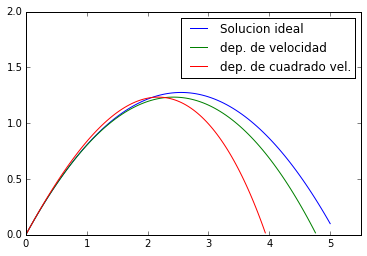

In [7]:
p = [0,0,5,5]
t,sol_id=rk4(e_mov,p,[0,1])
t,sol_fv=rk4(e_mov,p,[0,1],fric_v)
t,sol_fv2=rk4(e_mov,p,[0,1],fric_v2)
plot(sol_id[:,0],sol_id[:,1],label="Solucion ideal")
plot(sol_fv[:,0],sol_fv[:,1],label="dep. de velocidad")
plot(sol_fv2[:,0],sol_fv[:,1],label="dep. de cuadrado vel.")
xlim([0,5.5]),ylim([0,2])
legend()
show()

### ¿Y si queremos seguir modelando la trayectoria del objeto que se lanzó en tiro parabólico?

Lo que vamos a considerar es que el objeto rebota, entonces hay que determinar en que momento el objeto deja de caer... dicho punto lo vamos a renombar como el nuevo punto de inicio

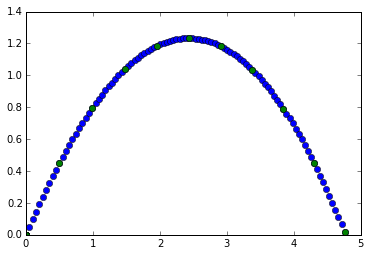

In [26]:
inicio = [0,0,5,5]
N = 500
trayectoria = zeros((500,len(inicio)))
mi_dt = .1
for i in range(N):
    t,sol_dt=rk4(e_mov,inicio,[0,mi_dt],fric_v)
    if sol_dt[-1,:][1] <0:
        break
    inicio = sol_dt[-1,:]
    trayectoria[i+1,:]=inicio
plot(sol_fv[:,0],sol_fv[:,1], 'o')
plot(trayectoria[:,0],trayectoria[:,1],'o')
#Estamos graficando la solución con la fricción dependiente de la velocidad 
#y la solución que estamos generando en 500 pasos con el ciclo for.

#Notemos que ambas coinciden.
show()

Queremos optimizar la función de las bolitas verdes (de ahora en adelante son verdes), e introducir la condición para que rebote, entonces vamos a reescribir el código con unas cuantas modificaciones:

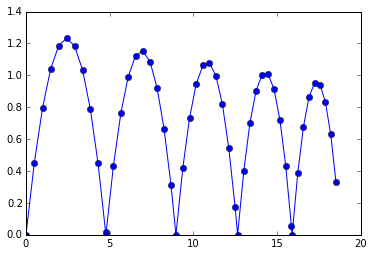

In [29]:
inicio = [0,0,5,5]
N = 50
trayectoria = zeros((N,len(inicio)))
mi_dt = .1
trayectoria[0,:]=array(inicio)
for i in range(N-1):
    t,sol_dt=rk4(e_mov,trayectoria[i,:],[0,mi_dt],fric_v)
    if sol_dt[-1,:][1] <0:
        punto = rebote(trayectoria[i,:],mi_dt)
        trayectoria[i+1,:] = punto
    else:
        trayectoria[i+1,:]=sol_dt[-1,:]
plot(trayectoria[:,0],trayectoria[:,1],'o-')
show()


In [12]:
#NOTA: el rebote se está haciendo sobre el eje x
def rebote(r_v_i,mi_dt):
    dt_busqueda = mi_dt/2
    y_izq = trayectoria[i,:]
    t,sol = rk4(e_mov,trayectoria[i,:],[0,dt_busqueda],fric_v)
    y_med = sol[-1,:]
    while abs(y_izq[1]) > 1e-5:
        if y_izq[1]*y_med[1] < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda],fric_v)
        y_izq = reinicio   
        y_med = sol[-1,:]
    y_izq=array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq